# Import dataset and a bit of data visualization

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

data = pd.read_csv('../data/creditcard.csv')
print(data.shape)
#data = data.iloc[:1000,:]

(284807, 31)


### Structure of the two classes 

Text(0, 0.5, 'Third component')

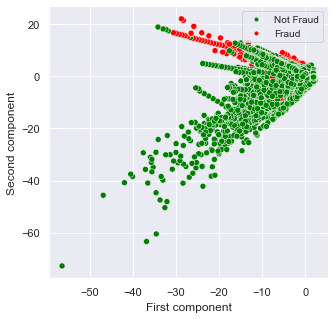

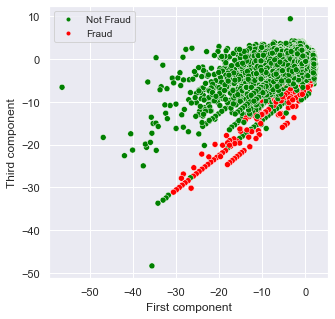

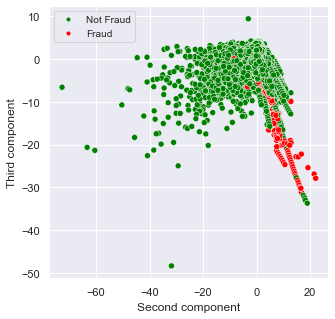

In [2]:
sns.set_theme()
sizeplots = (5,5)
sizelegend = 10
##########################################
#First Plot
plt.figure(figsize=sizeplots)

plot = sns.scatterplot(x = data["V1"],
                y = data["V2"],
                hue = data["Class"],
                palette = ["green", "red"],
                legend = False)

custom = [Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='red', linestyle='None')]
plt.legend(custom, ["Not Fraud", "Fraud"], prop={'size': sizelegend})
plt.xlabel("First component")
plt.ylabel("Second component")

##########################################
#Second Plot
plt.figure(figsize=sizeplots)

sns.scatterplot(x = data["V1"],
                y = data["V3"],
                hue = data["Class"],
                palette = ["green", "red"],
                legend = False)

custom = [Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='red', linestyle='None')]
plt.legend(custom, ["Not Fraud", "Fraud"], prop={'size': sizelegend})
plt.xlabel("First component")
plt.ylabel("Third component")

##########################################
#Third Plot
plt.figure(figsize=sizeplots)

sns.scatterplot(x = data["V2"],
                y = data["V3"],
                hue = data["Class"],
                palette = ["green", "red"],
                legend = False)

custom = [Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='red', linestyle='None')]
plt.legend(custom, ["Not Fraud", "Fraud"], prop={'size': sizelegend})
plt.xlabel("Second component")
plt.ylabel("Third component")

It seems that there are some patterns in the frauds, but must be considered that the dataset is higly unbalaced

## Data preparation

In [3]:
X = data.iloc[:,:-1]
y = data["Class"]
print("The features are: {}".format(list(X.columns)))
print("The variable of interest is: {}".format(y.name))

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("Number of samples of train set: {}".format(len(y_train)))
print("Number of samples of test set: {}".format(len(y_test)))

The features are: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
The variable of interest is: Class
Number of samples of train set: 199364
Number of samples of test set: 85443


## Evaluating Function

In [4]:
def evaluate_model_prediction(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_recall_fscore_support
    
    pr,rc,f1,su = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    print("""
    ----------------------------------------------------
    -Precision: {}
    -Recall: {}
    -F1 score: {}
    ----------------------------------------------------
    
    Confusion matrix:""".format(pr,rc,f1))
    
    
    sizeplots = (5,5)
    plt.figure(figsize=sizeplots)

    cm = confusion_matrix(y_true, y_pred)
    #cm_marginal = cm/cm.sum(axis=0)

    sns.heatmap(cm,
                fmt= ".5g",
                annot=True,
                annot_kws={"size": 15},
                cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

# Tree based models

## Decision tree

### Tree with sklearn's default tuning parameter -  Full tree


    ----------------------------------------------------
    -Precision: 0.7746478873239436
    -Recall: 0.7482993197278912
    -F1 score: 0.7612456747404844
    ----------------------------------------------------
    
    Confusion matrix:


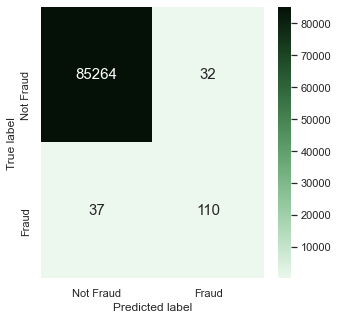

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt_default = DecisionTreeClassifier(random_state = 0) #uses gini impurity instead of entropy
dt_default.fit(X_train, y_train)
y_pred = dt_default.predict(X_test)
evaluate_model_prediction(y_test, y_pred)

The default decision tree classifies correctly almost all the non fraudolent transactions, and the 77% of the fraudolent predictions.

### Tree with tuning parameters optimization - Pruned tree

In [6]:
###################
#Around 7 minutes!#
###################

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

#Extract a portion of the train set for evaluating the best hyperparameters configuration
#using directly the test set would be unfair! B
#This because we will compare, in order to find the best model, all the models and using here the test 
#wound give an unfair advantage to this model
X_train_little, X_val, y_train_little, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)

dt = DecisionTreeClassifier(random_state = 0)

param_grid = ParameterGrid({
    'max_depth': np.arange(5, 32,4),
    'min_samples_leaf': 2 ** np.arange(5),
    "min_impurity_decrease": 10 ** np.arange(-5,-3,0.5)
})

results = []

for params in tqdm(param_grid):
    dt.set_params(**params)
    dt.fit(X_train_little, y_train_little)
    y_pred = dt.predict(X_val)
    params["f1_score"] = f1_score(y_val, y_pred)
    results.append(params)
    
results = pd.DataFrame(results)

#we want the model with the best f1score, in case of tie we choose the more parsimonious (Occam's razor)
results = results.sort_values(["f1_score","max_depth","min_impurity_decrease","min_samples_leaf"],                                        ascending = [False,True,False,False])
results.head(10)

,max_depth,min_impurity_decrease,min_samples_leaf,f1_score
21,9,0.00001,2,0.837736
20,9,0.00001,1,0.837736
41,13,0.00001,2,0.837736
40,13,0.00001,1,0.837736
61,17,0.00001,2,0.837736
60,17,0.00001,1,0.837736
81,21,0.00001,2,0.837736
80,21,0.00001,1,0.837736
101,25,0.00001,2,0.837736
100,25,0.00001,1,0.837736



    ----------------------------------------------------
    -Precision: 0.940677966101695
    -Recall: 0.7551020408163265
    -F1 score: 0.8377358490566039
    ----------------------------------------------------
    
    Confusion matrix:


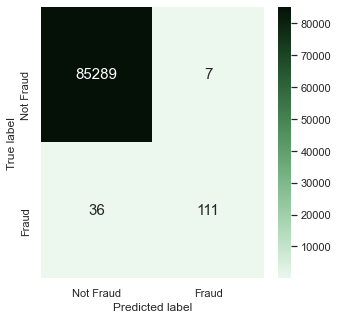

In [7]:
best_params = param_grid[results.index[0]]
dt.set_params(**best_params)
dt.fit(X_train, y_train) #train the best configured tree on the entire train set
y_pred = dt.predict(X_test)

evaluate_model_prediction(y_test, y_pred)

The optimazed tree performs better than the default one, maintaining almost all the not fradolent guesses correct (very little improvement), and increasing the amount of instances correctly classified as frauds up to 94%

## Random forest

### Trees bult on bootstrap replications with default parameters


    ----------------------------------------------------
    -Precision: 0.9310344827586207
    -Recall: 0.7346938775510204
    -F1 score: 0.8212927756653993
    ----------------------------------------------------
    
    Confusion matrix:


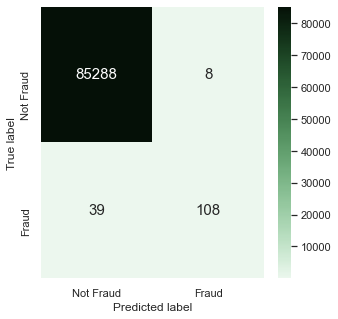

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_default = RandomForestClassifier(n_estimators=10, random_state = 0, bootstrap = True)
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_test)
evaluate_model_prediction(y_test, y_pred)

### Trees bult on bootstrap replications with optimal parameters
The ones that we found before during the tuning of the pruning tree


    ----------------------------------------------------
    -Precision: 0.9433962264150944
    -Recall: 0.6802721088435374
    -F1 score: 0.7905138339920947
    ----------------------------------------------------
    
    Confusion matrix:


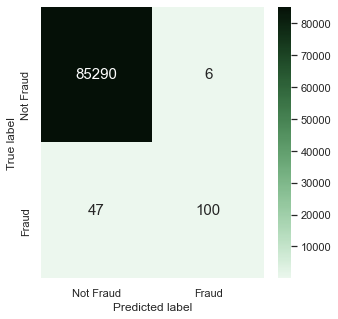

In [9]:
rf_optimized = RandomForestClassifier(n_estimators=100, random_state = 0, bootstrap = True)
rf_optimized.set_params(**best_params)
rf_optimized.fit(X_train, y_train)
y_pred = rf_optimized.predict(X_test)
evaluate_model_prediction(y_test, y_pred)

Random forest with optimal tree hyperparameters preforms worst that the optimal tree, because it has lower capability to find the fraudolent transactions.

## Boosting

### Gradient boosting


    ----------------------------------------------------
    -Precision: 0.8632478632478633
    -Recall: 0.6870748299319728
    -F1 score: 0.7651515151515151
    ----------------------------------------------------
    
    Confusion matrix:


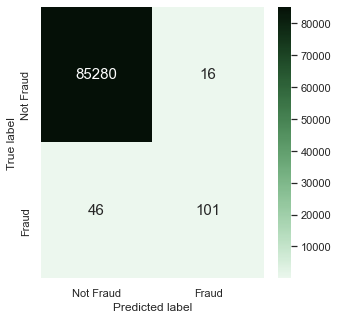

In [10]:
#####################
#Around 4-5 minutes!#
#####################

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
evaluate_model_prediction(y_test, y_pred)

### AdaBoost


    ----------------------------------------------------
    -Precision: 0.782258064516129
    -Recall: 0.6598639455782312
    -F1 score: 0.7158671586715867
    ----------------------------------------------------
    
    Confusion matrix:


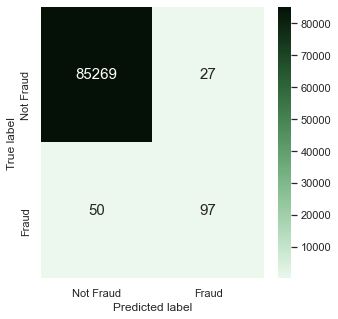

In [11]:
##################
#Around 1 minute!#
##################

from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(random_state=0)
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)
evaluate_model_prediction(y_test, y_pred)

Boosting methods didn't show good results, maybe they are too complicated models for highly unbalanced dataset such as this one.

# Alternative paradigms

## One class SVM

A method that estimate the support of the distribution of the data. We will estimate the distribution of genuine transactions and try to see if the fraudolent ones will fall outside of the estimated support, classifying those outliers as frauds.
We will undersample the train set in order to get reasonable execution time.

### Gaussian kernel

In [25]:
from sklearn.svm import OneClassSVM

X_OneClassSVM_train = X_train[y_train == 0,:]
n = X_OneClassSVM_train.shape[0]
n_samples = 30000
selected = np.floor(np.random.random_sample(n_samples)*n)
selected = np.int64(selected)


X_OneClassSVM_train = X_OneClassSVM_train[selected,:]
oc_svm = OneClassSVM(max_iter = -1)
oc_svm.fit(X_OneClassSVM_train) # Gaussian kernel

OneClassSVM()


    ----------------------------------------------------
    -Precision: 0.0033031907416951694
    -Recall: 0.9591836734693877
    -F1 score: 0.006583708822636752
    ----------------------------------------------------
    
    Confusion matrix:


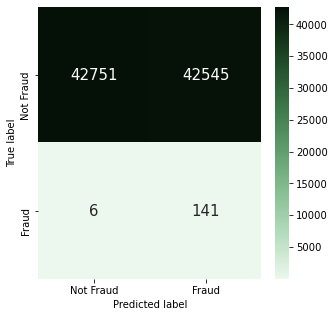

In [26]:
y_pred = oc_svm.predict(X_test)
y_pred = [0 if y == 1 else 1 for y in y_pred]
evaluate_model_prediction(y_test, y_pred)

This approach doesn't work well in this situation.

## Oversampling
We will use the smote tecnique on the train test in order to simulate new fraudolent observations.
This may leads to models that consider more the target class during their optimization procedure.
The test set won't be affected for fair comparisons.

In [1]:
import dill
dill.load_session('massimiliano_notebook_env.db')

In [12]:
import dill
dill.dump_session('massimiliano_notebook_env.db')